In [1]:
import pandas as pd
import numpy as np
import json
from pprint import pprint
import torch
import matplotlib.pyplot as plt
import torchtext
from sklearn.model_selection import train_test_split
from torchtext import data
import spacy
from torchtext import datasets
import random
import re
from torchtext import vocab
import torch.nn as nn
import torch.optim as optim

In [11]:
d=[]
with open('data/reviews.json') as f:
    for line in f:
        d.append(json.loads(line))
reviews=[i['reviewText'].lower() for i in d]
label=[i['overall'] for i in d]
del d
columns={'text':reviews,'label':label}
df=pd.DataFrame(data=columns)
del reviews
del label
df=df[df['label']!=3]
df['label'].replace(1,0,inplace=True)
df['label'].replace(2,0,inplace=True)
df['label'].replace(4,1,inplace=True)
df['label'].replace(5,1,inplace=True)
df_pos=df[df['label']==1]
df_neg=df[df['label']==0]
df_pos=df_pos.sample(df_neg.shape[0],random_state=0)
df=pd.concat([df_pos,df_neg])
df=df.reset_index(drop=True)
train,test=train_test_split(df,test_size=0.2,random_state=0)
train=train.reset_index(drop=True)
test=test.reset_index(drop=True)
del df

In [9]:
text_field=data.Field()
label_field=data.LabelField(dtype=torch.float)
fields = [('text',text_field),('label',label_field),(None, None)]

In [12]:
class PredictSentimentDataset(torchtext.data.Dataset):
    def __init__(self, dataframe, TEXT, LABEL, **kwargs):
        fields = [("text", TEXT), ("label", LABEL),(None, None)]
        examples = []
        for i in range(dataframe.values[:,1].shape[0]):
            text = dataframe.text[i] 
            label = dataframe.label[i]
            examples.append(data.Example.fromlist([text, label], fields))
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex): return len(ex.Description)
    
    @classmethod
    def splits(cls, text_field, label_field, root='data',
               train='train', test='test', **kwargs):
        return super().splits(
            root, text_field=text_field, label_field=label_field,
            train=train, validation=None, test=test, **kwargs)

In [13]:
train=PredictSentimentDataset(train,text_field,label_field)
test=PredictSentimentDataset(test,text_field,label_field)

In [14]:
train_data, valid_data = train.split(split_ratio=0.85,random_state=random.seed(0))

In [15]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test)}')

Number of training examples: 1004962
Number of validation examples: 177346
Number of testing examples: 295578


In [16]:
text_field.build_vocab(train_data,max_size=25000)
label_field.build_vocab(train_data)

In [17]:
print(f"Unique tokens in TEXT vocabulary: {len(text_field.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(label_field.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [18]:
del train

In [19]:
BATCH_SIZE = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test), batch_size=BATCH_SIZE,device=device)
train_iterator = data.BucketIterator(train_data , batch_size=BATCH_SIZE,device=device)
valid_iterator = data.BucketIterator(valid_data, batch_size=BATCH_SIZE,device=device)
test_iterator = data.BucketIterator(test, batch_size=BATCH_SIZE,device=device)


In [20]:
len(train_iterator)

20100

In [21]:
class Model(nn.Module):
    def __init__( self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional):
        super().__init__()
        
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.rnn=nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        #self.dropout=nn.Dropout(dropout)
        
    def forward(self,x):
        out=self.embedding(x)
        out,(hidden,cell)=self.rnn(out)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out=self.fc(hidden.squeeze(0))
        
        return out

In [22]:
INPUT_DIM = len(text_field.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

model = Model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL)

In [23]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [24]:
model = model.to(device)
criterion = criterion.to(device)

In [25]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [26]:
def train(model, iterator, optimizer, criterion,epochs,num_epochs):
    epoch_loss = 0
    model.train()
    counter=1
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        rl.append(loss)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        counter=counter+1
        
        if(counter%2010==0):
            print('Epoch: [{}/{}] | Step: [{}/{}] | Loss: {} |'.format(epochs+1, num_epochs, int((counter)/2010),10 , round(epoch_loss/2010,3)))
            #counter=0
            epoch_loss=0
        
    #return epoch_loss / len(iterator)


In [27]:
def evaluate(model, iterator):
    epoch_acc = 0
    model.eval()
    for batch in iterator:
        predictions = model(batch.text).squeeze(1)
        accuracy = binary_accuracy(predictions, batch.label)
        epoch_acc += accuracy.item()
        
    return epoch_acc / len(iterator)

In [28]:
checkpoint = torch.load('model_1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
rl = checkpoint['loss']
acc=checkpoint['validation_accuracy']

model.eval()

Model(
  (embedding): Embedding(25002, 100)
  (rnn): LSTM(100, 64, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Epoch: [2/3] | Step: [1/10] | Loss: 0.133 |
Epoch: [2/3] | Step: [2/10] | Loss: 0.131 |
Epoch: [2/3] | Step: [3/10] | Loss: 0.13 |
Epoch: [2/3] | Step: [4/10] | Loss: 0.129 |
Epoch: [2/3] | Step: [5/10] | Loss: 0.13 |
Epoch: [2/3] | Step: [6/10] | Loss: 0.129 |
Epoch: [2/3] | Step: [7/10] | Loss: 0.129 |
Epoch: [2/3] | Step: [8/10] | Loss: 0.128 |
Epoch: [2/3] | Step: [9/10] | Loss: 0.129 |
Epoch: [2/3] | Step: [10/10] | Loss: 0.128 |
| Epoch: 02 | Val. Acc: 94.74% | ---%Saving the model%---
Epoch: [3/3] | Step: [1/10] | Loss: 0.102 |
Epoch: [3/3] | Step: [2/10] | Loss: 0.105 |
Epoch: [3/3] | Step: [3/10] | Loss: 0.109 |
Epoch: [3/3] | Step: [4/10] | Loss: 0.107 |
Epoch: [3/3] | Step: [5/10] | Loss: 0.105 |
Epoch: [3/3] | Step: [6/10] | Loss: 0.106 |
Epoch: [3/3] | Step: [7/10] | Loss: 0.11 |
Epoch: [3/3] | Step: [8/10] | Loss: 0.112 |
Epoch: [3/3] | Step: [9/10] | Loss: 0.11 |
Epoch: [3/3] | Step: [10/10] | Loss: 0.11 |
| Epoch: 03 | Val. Acc: 94.86% | ---%Saving the model%---


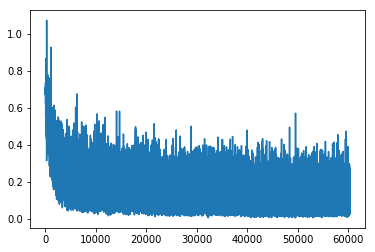

In [46]:
N_EPOCHS = 2
#rl=[]
#acc=[]
for epochs in range(epoch,epoch+N_EPOCHS):
    train(model, train_iterator, optimizer, criterion,epochs,N_EPOCHS+epoch)
    valid_acc = evaluate(model, valid_iterator)
    acc.append(valid_acc)
    print(f'| Epoch: {epochs+1:02} | Val. Acc: {valid_acc*100:.2f}% | ---%Saving the model%---')
    torch.save({
            'epoch': int(len(acc)),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': rl,
            'validation_accuracy':acc,
            },'model_{}.pth'.format(int(len(acc))))
plt.plot(range(len(rl)),rl)

In [47]:
print(evaluate(model, test_iterator))

0.9502198696338114


## User Input ##


In [40]:
nlp=spacy.load('en')
def predictsentiment(sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [text_field.vocab.stoi[t] for t in tokenized]
    tensor=torch.LongTensor(indexed).to(device)
    tensor=tensor.unsqueeze(1)
    prediction=torch.sigmoid(model(tensor))
    p=prediction.item()
    if(p<0.5):
        print ('positive')
    if(p>0.5):
        print ('negative')
    

In [94]:
predictsentiment('Our economy is in a midst of a revolution. Demonetization, introduction of GST and recapitalization of banks may prove to be a game changer ')

positive
